# 分子動力学プログラム LAMMPS を Amazon SageMaker Processing で GPU を用いて動かすサンプル

* [LAMMPS](https://www.lammps.org/) を Amazon SageMaker Processing で動かす。細かい情報は下記を参照。
    * [LAMMPSのマニュアル](https://docs.lammps.org/Manual.html)
    * [ポリエチレン分子をシミュレーション](https://winmostar.com/jp/tutorials/LAMMPS_tutorial_8%28Polymer_Elongation%29.pdf)
    * [SageMaker SDK doc](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_processing.html)
    * [SageMaker Processing 開発者ガイド](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html)

このノートブックは Amazon SageMaker Notebook(≠Studio) の GPU インスタンス(g4dn.xlargeなど)で実行することを前提とする。理由は以下の通り。

1. docker コマンドを使うため(Studioを使う場合は sm-docker コマンドに修正の必要あり)
2. ビルドしたコンテナをローカル(SageMaker Notebook内)でテスト実行するのにあたり、GPU で動かす必要があるため

In [ ]:
# 使用するライブラリを読み込み
import boto3, sagemaker, os, shutil, re
from sagemaker.processing import ScriptProcessor, ProcessingInput, ProcessingOutput
import pandas as pd
from matplotlib import pyplot as plt
from io import StringIO

## コンテナイメージのビルド
まずは SageMaker Processing で LAMMPS が動かせるよう、コンテナイメージの中で LAMMPS をビルドする。  
### ビルド環境のセットアップ
ビルドは、`/var/lib/docker`を利用するが、SageMaker Notebook では該当領域は`/` にマウントされた 15GB では、ビルドに耐えられないので、別途 EBS をマウントしている`/home/ec2-user/SageMaker`以下の領域を使うように変更するスクリプトを実行する

In [ ]:
cat ./setup.sh

In [ ]:
!./setup.sh

### ビルド

In [ ]:
%%time

IMAGE_NAME = 'lampps'
TAG=':v1'

%cd ./container
!docker stop $(docker ps -q)
!docker rm $(docker ps -q -a)
# !docker rmi -f $(docker images -a -q)
!docker build -t {IMAGE_NAME}{TAG} .
%cd ../

### Image Test
ビルドしたイメージをテストする。  
このインスタンスでコンテナを動かし、mpirunコマンド(`./lmp_equiliv.sh`に内包)を実行し実際にシミュレーションを行う。  

jupyter notebook の new -> terminal から下記セルの出力をコピーして実行

In [ ]:
command_str = f"""
cd {os.getcwd()} # clone した先のディレクトリに cd

docker run --gpus all -v {os.getcwd()}/test/:/test -it --rm --entrypoint "bash" {IMAGE_NAME}{TAG}

cd /test

./lmp_equiliv.sh

tail -n1 lmp_equiliv.log # 実行時間が出ていたらOK, 概ね g4dn.xlarge で 6 分弱で完了

tail -n1 lmp2data_equiliv.log  # finish replica が出ていたらOK

exit # 終わったら exit でコンテナから抜ける(コンテナも終了する)
"""
print(command_str)

### Push

In [ ]:
%%time

MY_ACCOUNT_ID = boto3.client('sts').get_caller_identity().get('Account')
# PUBLIC_ACCOUNT_ID = '763104351884'

REGION = boto3.session.Session().region_name

MY_ECR_ENDPOINT = f'{MY_ACCOUNT_ID}.dkr.ecr.{REGION}.amazonaws.com/'



MY_REPOSITORY_URI = f'{MY_ECR_ENDPOINT}{IMAGE_NAME}'
MY_IMAGE_URI = f'{MY_REPOSITORY_URI}{TAG}'

!$(aws ecr get-login --region {REGION} --registry-ids {MY_ACCOUNT_ID} --no-include-email)
 
# リポジトリの作成
!aws ecr delete-repository --repository-name {IMAGE_NAME} --force # 同名のリポジトリがあった場合削除
!aws ecr create-repository --repository-name {IMAGE_NAME}
 
# !docker push $image_uri
!docker tag {IMAGE_NAME}{TAG} {MY_IMAGE_URI}
!docker push {MY_IMAGE_URI}

print(f'コンテナイメージは {MY_IMAGE_URI} へ登録されています。')

## SageMaker Processing で ポリエチレンのシミュレーション
* コンテナイメージの作成が完了したので、シミュレーションのジョブを投入する
* 以降重い処理はこのノートブックインスタンスで実行することはなく、ただジョブの投入を行うだけなので、t3.mediumなどでも十分動く

### 必要なデータ(パラメータファイルなど)を S3 にアップロード

In [33]:
prefix = 'lammps_simple'
input_s3_uri = sagemaker.session.Session().upload_data(path='param/', key_prefix=prefix)
print(input_s3_uri)

s3://sagemaker-ap-northeast-1-155580384669/lammps_simple


### SageMaker Processing の実行パラメータを設定

In [34]:
# S3 から SageMaker Processing インスタンスへの転送先
PROCESSING_INPUT_DIR = '/opt/ml/processing/input/'

# SageMaker Processing インスタンス内の結果出力先
PROCESSING_OUTPUT_DIR = '/opt/ml/processing/output'

In [35]:
processor = sagemaker.processing.ScriptProcessor(
    base_job_name='LAMMPS-polyethylene',
    image_uri=MY_IMAGE_URI,
    command=['python'],
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.g4dn.xlarge'
)

### SageMaker Processing でシミュレーションを実行
* 成功していたら最後に `finish replica` と表示される

In [36]:
processor.run(
    # Processing インスタンスで実行するコード
    # S3 の URI でも OK
    # ScriptProcessor のコマンドの第一引数になる(この場合は python run.py)
    # 配置場所はデフォルトで/opt/ml/processing/input/code/の下
    code='src/run.py',
    
    # ジョブ開始前に S3 から Processing インスタンス に転送するデータの設定
    # input_s3_uri 以下にあるファイル群が PROCESSING_INPUT_DIR に配置される
    inputs=[ProcessingInput(source=input_s3_uri,destination=PROCESSING_INPUT_DIR),],
    
    # ジョブ完了後に Processing インスタンスから S3 に転送する設定
    # PROCESSING_OUTPUT_DIR に配置したものが、s3://{default bucket}/{base_job_name}-YYYY-MM-DD-HH-MI-SS-mmm/output/result/以下に配置される
    outputs=[ProcessingOutput(output_name='result',source=PROCESSING_OUTPUT_DIR),],
    
    # コマンド実行時の第 2 引数以降に設定される
    # この場合は python /opt/ml/processing/input/code/run.py --input-dir $PROCESSING_INPUT_DIR --input-equiliv-in lmp_equiliv.in …
    # となる
    arguments=[
        '--input-dir', PROCESSING_INPUT_DIR,
        '--output-dir',PROCESSING_OUTPUT_DIR,
    ]
)


Job Name:  LAMMPS-polyethylene-2021-10-16-07-52-49-377
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-1-155580384669/lammps_simple', 'LocalPath': '/opt/ml/processing/input/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-1-155580384669/LAMMPS-polyethylene-2021-10-16-07-52-49-377/input/code/run.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-ap-northeast-1-155580384669/LAMMPS-polyethylene-2021-10-16-07-52-49-377/output/result', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
..........................................

## シミュレーション結果の確認
### ジョブの結果詳細確認

In [ ]:
# 実行したジョブの詳細確認
print(processor.latest_job.describe())

### ジョブの出力結果を取得

In [ ]:
job_name = processor.latest_job.describe()['ProcessingJobName']
output_s3_uri = processor.latest_job.describe()['ProcessingOutputConfig']['Outputs'][0]['S3Output']['S3Uri']
print(job_name, output_s3_uri)

In [ ]:
# ローカル(ノートブックインスタンス)にダウンロード
!mkdir ./{job_name}
!aws s3 sync {output_s3_uri} ./{job_name}

## (応用編1)ポリエチレンのシミュレーションをグリッドサーチ
* パラメータを変えながら一気にジョブを投入する
* シミュレーションの開始時の温度を 2パターン (540K,550K)用意して、一気にジョブを流す
* param_base/lmp_equliv.in に変数を変えるためのプレースホルダを事前に用意し、実行する時に書き換えてジョブを流す

In [ ]:
# tmpe1_1_variable という文字列がプレースホルダで、動的に書き換える
!head -n12 ./param_base/lmp_equiliv.in

In [30]:
# S3 から SageMaker Processing インスタンスへの転送先
PROCESSING_INPUT_DIR = '/opt/ml/processing/input/'
# SageMaker Processing インスタンス内の結果出力先
PROCESSING_OUTPUT_DIR = '/opt/ml/processing/output'

processor = sagemaker.processing.ScriptProcessor(
    base_job_name='LAMMPS-polyethylene-grid',
    image_uri=MY_IMAGE_URI,
    command=['python'],
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.g4dn.xlarge'
)

for i,kervin in enumerate([540,550]):
    # S3 にアップロード
    prefix = f'lammps_grid_{str(i)}'
    input_s3_uri = sagemaker.session.Session().upload_data(path='param_base/', key_prefix=prefix)
    print(input_s3_uri)
    
    processor.run(
        code='src_grid/run.py',
        inputs=[ProcessingInput(source=input_s3_uri,destination=PROCESSING_INPUT_DIR),],
        outputs=[ProcessingOutput(output_name='result',source=PROCESSING_OUTPUT_DIR),],
        arguments=[
            '--input-dir',         PROCESSING_INPUT_DIR,
            '--output-dir',        PROCESSING_OUTPUT_DIR,
            '--np',                '2',
            '--gpu',               '1',
            '--tempe1-1-variable', str(kervin),
            '--tempe1-2-variable', '550',
            '--dt1-variable',      '1.6',
            '--nrun1-variable',    'ceil(1e5)'
        ],
        wait=False # ジョブの完了を待たずにすぐに結果を返す
    )

# ジョブが終わるまで待つ
for job in processor.jobs:
    job.wait()
    

s3://sagemaker-ap-northeast-1-155580384669/lammps_grid_0

Job Name:  LAMMPS-polyethylene-grid-2021-10-16-07-35-00-358
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-1-155580384669/lammps_grid_0', 'LocalPath': '/opt/ml/processing/input/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-1-155580384669/LAMMPS-polyethylene-grid-2021-10-16-07-35-00-358/input/code/run.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-ap-northeast-1-155580384669/LAMMPS-polyethylene-grid-2021-10-16-07-35-00-358/output/result', 'LocalPath': '/opt/ml/processing/output', 


Received arguments Namespace(input_dir='/opt/ml/processing/input/', input_equiliv_in='lmp_equiliv.in', input_equiliv_sh='lmp_equiliv.sh', input_lmp2data_py='lmp2data.py', np='2', gpu='1', output_dir='/opt/ml/processing/output', tempe1_1_variable='550', tempe1_2_variable='550', dt1_variable='1.6', nrun1_variable='ceil(1e5)', logfile_name='lmp_equiliv.log')
change directory
check current directory
total 1808
drwxr-xr-x 2 root root    4096 Oct 16 07:39 code
-rw-r--r-- 1 root root    2751 Oct 16 07:39 lmp2data.py
-rw-r--r-- 1 root root    1758 Oct 16 07:39 lmp_equiliv.in
-rw-r--r-- 1 root root     356 Oct 16 07:39 lmp_equiliv.sh
-rw-r--r-- 1 root root 1831484 Oct 16 07:39 lmp_tmp1.data

replace parameter
tempe1_1_variable: 550
tempe1_2_variable: 550
dt1_variable: 1.6
nrun1_variable: ceil(1e5)
mpi will be started with following command.
bash lmp_equiliv.sh 2 1 /program/lammps201029/build/lmp lmp_equiliv.in /opt/ml/processing/input/lmp_equiliv.log
LAMMPS (29 Oct 2020)
  using 1 OpenMP threa

In [31]:
# ジョブの結果を手元にダウンロード
for job in processor.jobs:
    !mkdir -p {job.describe()['ProcessingJobName']}
    !aws s3 sync {job.describe()['ProcessingOutputConfig']['Outputs'][0]['S3Output']['S3Uri']} {job.describe()['ProcessingJobName']}

download: s3://sagemaker-ap-northeast-1-155580384669/LAMMPS-polyethylene-grid-2021-10-16-07-35-00-358/output/result/1.csv to LAMMPS-polyethylene-grid-2021-10-16-07-35-00-358/1.csv
download: s3://sagemaker-ap-northeast-1-155580384669/LAMMPS-polyethylene-grid-2021-10-16-07-35-00-358/output/result/lmp2data_stderr.txt to LAMMPS-polyethylene-grid-2021-10-16-07-35-00-358/lmp2data_stderr.txt
download: s3://sagemaker-ap-northeast-1-155580384669/LAMMPS-polyethylene-grid-2021-10-16-07-35-00-358/output/result/log.lammps to LAMMPS-polyethylene-grid-2021-10-16-07-35-00-358/log.lammps
download: s3://sagemaker-ap-northeast-1-155580384669/LAMMPS-polyethylene-grid-2021-10-16-07-35-00-358/output/result/0.csv to LAMMPS-polyethylene-grid-2021-10-16-07-35-00-358/0.csv
download: s3://sagemaker-ap-northeast-1-155580384669/LAMMPS-polyethylene-grid-2021-10-16-07-35-00-358/output/result/lmp_equiliv.log to LAMMPS-polyethylene-grid-2021-10-16-07-35-00-358/lmp_equiliv.log
download: s3://sagemaker-ap-northeast-1-15

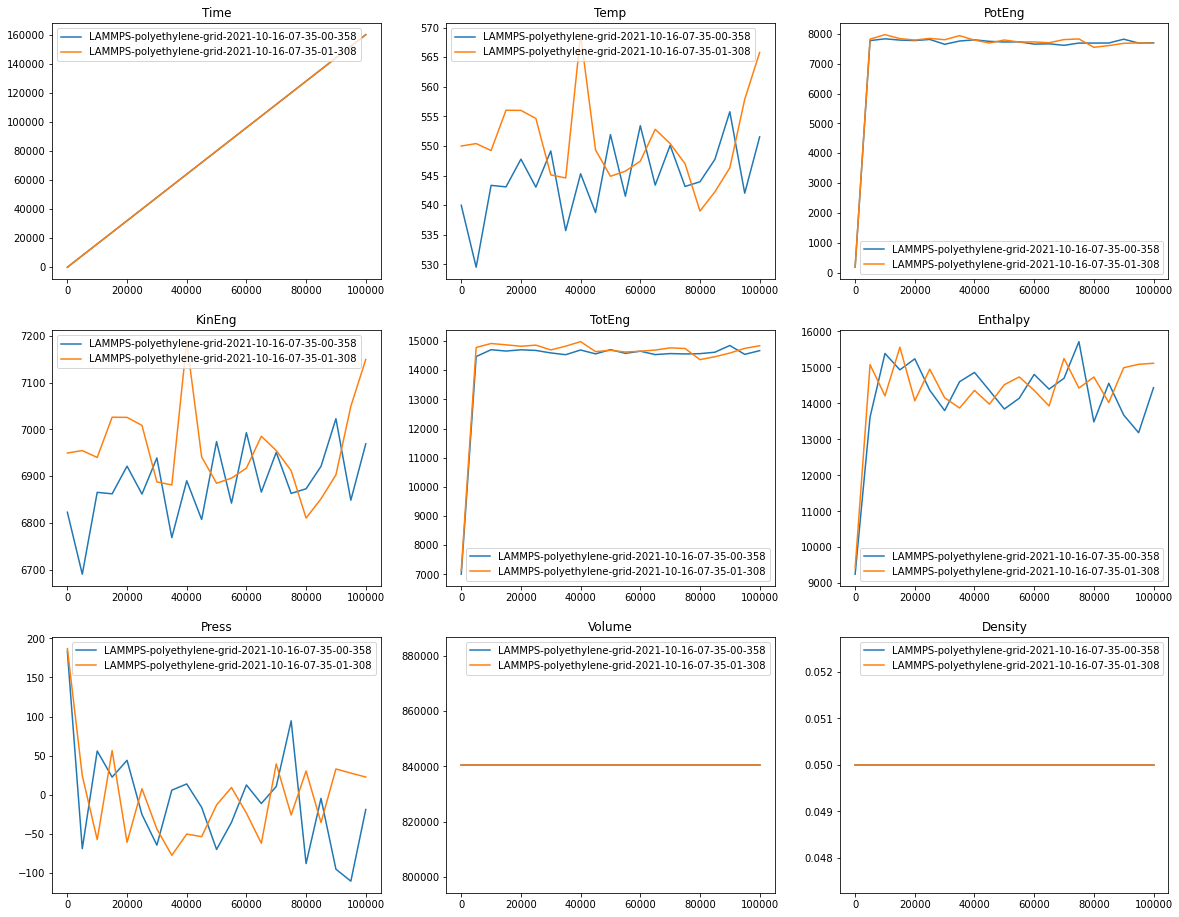

In [32]:
# 可視化
dfs = {}
for job in processor.jobs:
    directory = job.describe()['ProcessingJobName']
    dfs[directory] = pd.read_csv(f'{directory}/1.csv')
fig = plt.figure(figsize=(20,16))
for i,column in enumerate(dfs[directory].columns[1:]):
    ax = fig.add_subplot(3,3,i+1)
    ax.set_title(column)
    for key in dfs:
        ax.plot(dfs[key]['Step'],dfs[key][column],label=key)
    ax.legend()


## (応用編2) SageMaker Processing のデバッグ

SageMaker Processing はインスタンス起動やイメージ Pull のオーバヘッドがあるため、新しく作った（動くか不安な）コードをProcessingで動かすのは効率が悪い。  
Notebookインスタンス上で実行してデバッグする方法を記載する。S3 のデータ受け渡しは割愛し、/opt/ml/input/以下に必要なデータがあり、/opt/ml/output/にデータを出力するところまでを確認する

In [ ]:
command_str = f"""
cd {os.getcwd()} # clone した先のディレクトリに cd

# Debug 用
docker run --gpus all -v {os.getcwd()}/debug/:/opt/ml/processing/ -it --rm --entrypoint "bash" {IMAGE_NAME}{TAG}

# 実行用
docker run --gpus all -v {os.getcwd()}/debug/:/opt/ml/processing/ -it {IMAGE_NAME}{TAG} /opt/ml/processing/input/code/run.py --input-dir {PROCESSING_INPUT_DIR} --input-equiliv-in lmp_equiliv.in --input-equiliv-sh lmp_equiliv.sh --input-lmp2data-py lmp2data.py --np 2 --gpu 1 --output-dir {PROCESSING_OUTPUT_DIR} 
"""
print(command_str)

## SageMaker Experiments を用いてシミュレーションの実験管理を行う

In [ ]:
# sagemaker experiments SDK のインストール
!pip install sagemaker-experiments

In [ ]:
from smexperiments import experiment
from smexperiments.experiment import Experiment
from sagemaker.analytics import ExperimentAnalytics
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
import time

In [ ]:
my_lammps_experiment = experiment.Experiment.create(experiment_name='my-LAMMPS-experiments')

In [ ]:
my_trial = my_lammps_experiment.create_trial(trial_name='simple-trial')

In [ ]:
# 工事中
# metric_definitions = [
#     {'Name': 'tempe1_1','Regex': 'tempe1_1_variable: ([0-9\\.]+)'},
#     {'Name': 'tempe1_2','Regex': 'tempe1_2_variable: ([0-9\\.]+)'},
#     {'Name': 'dt1','Regex': 'dt1_variable: ([0-9\\.]+)'},
#     {'Name': 'nrun1','Regex': 'nrun1_variable: ([a-z0-9\\(\\)\\.]+)'},
# ]

In [ ]:
# S3 から SageMaker Processing インスタンスへの転送先
PROCESSING_INPUT_DIR = '/opt/ml/processing/input/'
# SageMaker Processing インスタンス内の結果出力先
PROCESSING_OUTPUT_DIR = '/opt/ml/processing/output'

processor = sagemaker.processing.ScriptProcessor(
    base_job_name='LAMMPS-polyethylene-grid',
    image_uri=MY_IMAGE_URI,
    command=['python'],
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    # ------工事中------
    #     metric_definitions=metric_definitions, # metrics 定義を指定
    # ------工事中------
)

for i,kervin in enumerate([540,550]):
    # S3 にアップロード
    prefix = f'lammps_grid_{str(i)}'
    input_s3_uri = sagemaker.session.Session().upload_data(path='param_base/', key_prefix=prefix)
    print(input_s3_uri)
    my_trial = my_lammps_experiment.create_trial(trial_name=f'simple-trial-tempe1-1-{str(kervin)}')
    processor.run(
        code='src_grid/run.py',
        inputs=[ProcessingInput(source=input_s3_uri,destination=PROCESSING_INPUT_DIR),],
        outputs=[ProcessingOutput(output_name='result',source=PROCESSING_OUTPUT_DIR),],
        arguments=[
            '--input-dir',         PROCESSING_INPUT_DIR,
            '--input-equiliv-in',  'lmp_equiliv.in',
            '--input-equiliv-sh',  'lmp_equiliv.sh',
            '--input-lmp2data-py', 'lmp2data.py',
            '--np',                '2',
            '--gpu',               '1',
            '--output-dir',        PROCESSING_OUTPUT_DIR,
            '--tempe1-1-variable', str(kervin),
            '--tempe1-2-variable', '550',
            '--dt1-variable',      '1.6',
            '--nrun1-variable',    'ceil(1e5)'
        ],
        wait=False, # ジョブの完了を待たずにすぐに結果を返す
        experiment_config={
            "ExperimentName": my_lammps_experiment.experiment_name,
            "TrialName": my_trial.trial_name,
            "TrialComponentDisplayName": "polyethylene-simulation"
        }
    )

# ジョブが終わるまで待つ
for job in processor.jobs:
    job.wait()
    

In [ ]:
trial_component_analytics = ExperimentAnalytics(
    experiment_name=my_lammps_experiment.experiment_name,
)

analytic_table = trial_component_analytics.dataframe()

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
analytic_table

In [ ]:
def cleanup_sme_sdk(experiment):
    for trial_summary in experiment.list_trials():
        trial = Trial.load(trial_name=trial_summary.trial_name)
        for trial_component_summary in trial.list_trial_components():
            tc = TrialComponent.load(
                trial_component_name=trial_component_summary.trial_component_name)
            trial.remove_trial_component(tc)
            try:
                # comment out to keep trial components
                tc.delete()
            except:
                # tc is associated with another trial
                continue
            # to prevent throttling
            time.sleep(.5)
        trial.delete()
        experiment_name = experiment.experiment_name
    experiment.delete()
    print(f"\nExperiment {experiment_name} deleted")

In [ ]:
experiment_to_cleanup = Experiment.load(
    # Use experiment name not display name
    experiment_name=my_lammps_experiment.experiment_name)

cleanup_sme_sdk(experiment_to_cleanup)

In [ ]:
sm_client = boto3.client('sagemaker')

In [ ]:
processing_job_list = sm_client.list_processing_jobs(SortBy='CreationTime',SortOrder='Descending',MaxResults=1)['ProcessingJobSummaries']

In [ ]:
for job in processing_job_list:
    if 'LAMMPS' in job['ProcessingJobName']:
        print(sm_client.describe_processing_job(ProcessingJobName=job['ProcessingJobName']))

In [ ]:
job_description = sm_client.describe_processing_job(ProcessingJobName=job['ProcessingJobName'])
job_description

In [ ]:
job_description['AppSpecification']